## Importing stuff

In [2]:
import ipynb
import numpy as np
import matplotlib.pyplot as plt
import pylcp
import scipy.constants as consts
import lmfit
from pylcp.common import progressBar
import ast
import csv
import pickle
from scipy.optimize import bisect
from tqdm import tqdm
from ipynb.fs.full.MagnetsInterpolation import ComsolMagCylindricalInterpolation as mi
import inspect

loadpath = "./csv/"
savepath = "./images/"

## Laser parameters and scaled units

In [47]:
# #laser parameters
# laser_det = -2
# ham_det = 0
# #laser power in Watts
# laser_power = 0.1
# #beam intensity 1/e^2 radius in cm
# beamWidth = 0.4
# #saturation intensity in W/cm^2
# Isat = 1
# s = laser_power/(Isat*np.pi*beamWidth**2)

import matplotlib as mpl

rcparams = {
# 'axes.titlesize'    : 18,
# 'axes.labelsize'    : 16,
# 'xtick.labelsize'   : 12,
# 'ytick.labelsize'   : 12,
# 'legend.fontsize'   : 12,
'font.size'         : 20
}
for e in rcparams.keys():
    mpl.rcParams[e] = rcparams[e]

k = 4369238.4 # m^-1

hbar = consts.hbar
h = consts.h

hertz_unit = 91e6#19.15*4369238.4
time_unit = 1/hertz_unit

amu_const = consts.value('atomic mass constant')

#scaled mass as described in the examples, for 114 Cd
scaledMass = 4.87e-3
print(scaledMass)
scaledMass = 113.9*amu_const*91*(2*np.pi)/(hbar*2*np.pi*k**2)
print(scaledMass)
amu_unit = 113.90336500/scaledMass
velocity_unit = hertz_unit/k


# laser parameters from Simon
slower_beam_width = 0.5
slower_I = 0.3
slower_detuning = 0 # Placeholder
MOT_detuning = -1.45*100e6/hertz_unit
MOT_beam_width = 0.4
Isat = 1.1
slower_s = slower_I/Isat
# slower_s = 0.02
MOT_s = 2
cm_unit = 1


# Some parameters for the MOT
# Mass taken from IAEA
mass = {106 : 105.9064598/amu_unit, 108 : 107.9041836/amu_unit, 110 : 109.9030075/amu_unit, 111 : 110.9041838/amu_unit, 112 : 111.90276390/amu_unit, 113 : 112.90440811/amu_unit, 114 : 113.90336500/amu_unit, 116 : 115.90476323/amu_unit}
abundance_data = {106 : 0.0125, 108 : 0.0089, 110 : 0.1249, 111 : 0.1280, 112 : 0.2413, 113 : 0.1222, 114 : 0.2873, 116 : 0.0749}

# Take isotope shift data from here: https://arxiv.org/pdf/2210.11425.pdf [Table II, this work]
isotope_shifts = {106 : 2*np.pi*1818.1e6/hertz_unit, 108 : 2*np.pi*1336.5e6/hertz_unit, 110 : 2*np.pi*865e6/hertz_unit, 111 : 2*np.pi*805.0e6/hertz_unit, 112 : 2*np.pi*407.5e6/hertz_unit, 113 : 2*np.pi*344.9e6/hertz_unit, 114 : 2*np.pi*0e6/hertz_unit, 116 : -2*np.pi*316.1e6/hertz_unit}
isotope_shift_hyperfine = {111 : 2*np.pi*(899.2e6 - 616.5e6)/hertz_unit, 113 : 2*np.pi*(443.4e6 - 147.8e6)/hertz_unit}

# Hamiltonians
ham_det = 0

def gen_Boson_Hamiltonian(isotope = 114):
    Hg, Bgq = pylcp.hamiltonians.singleF(F=0, gF=0, muB=1)
    He, Beq = pylcp.hamiltonians.singleF(F=1, gF=1, muB=1)
    dijq = pylcp.hamiltonians.dqij_two_bare_hyperfine(0, 1)
    return pylcp.hamiltonian(Hg, He + (isotope_shifts[isotope] - ham_det)*np.eye(3), Bgq, Beq, dijq,mass=mass[isotope],k=1, gamma=1,muB=1)

def gen_Fermion_Hamiltonian(isotope = 111):
    #Hamiltonian for F=1/2 -> F = 1/2,3/2 
    HgFermion, BgqFermion = pylcp.hamiltonians.hyperfine_coupled(J=0, I=1/2, gJ=0, gI=0, Ahfs=0, Bhfs=0, Chfs=0, muB=1)
    # HeFermion, BeqFermion = pylcp.hamiltonians.hyperfine_coupled(J=1, I=1/2, gJ=1, gI=0, Ahfs=2.2, Bhfs=0, Chfs=0, muB=1)
    Ahfs = 2*isotope_shift_hyperfine[isotope]/3
    HeFermion, BeqFermion = pylcp.hamiltonians.hyperfine_coupled(J=1, I=1/2, gJ=1, gI=0, Ahfs=Ahfs, Bhfs=0, Chfs=0, muB=1)
    dijqFermion = pylcp.hamiltonians.dqij_two_hyperfine_manifolds(J=0, Jp=1, I=0.5)
    return pylcp.hamiltonian(HgFermion, HeFermion + (isotope_shifts[isotope] - ham_det)*np.eye(6), BgqFermion, BeqFermion, dijqFermion,mass=mass[isotope],k=1, gamma=1,muB=1)

Hamiltonians = {}
# Generate all Hamiltonians
for key in mass.keys():
    if (key in isotope_shift_hyperfine.keys()):
        Hamiltonians[key] = gen_Fermion_Hamiltonian(key)
        continue
    Hamiltonians[key] = gen_Boson_Hamiltonian(key)


# Laser fields
def MOT_and_Slow_Beams(det_MOT, det_slower):
    return pylcp.laserBeams([
        {'kvec':np.array([-1/np.sqrt(2), -1/np.sqrt(2), 0.]), 'pol':-1, 'delta':0*MOT_detuning + det_MOT, 's':MOT_s,'wb':MOT_beam_width},
        {'kvec':np.array([1/np.sqrt(2), 1/np.sqrt(2), 0.]), 'pol':-1, 'delta':0*MOT_detuning + det_MOT, 's':MOT_s,'wb':MOT_beam_width},
        {'kvec':np.array([1/np.sqrt(2), -1/np.sqrt(2), 0.]), 'pol':-1, 'delta':0*MOT_detuning + det_MOT, 's':MOT_s,'wb':MOT_beam_width},
        {'kvec':np.array([-1/np.sqrt(2), 1/np.sqrt(2), 0.]), 'pol':-1, 'delta':0*MOT_detuning + det_MOT, 's':MOT_s,'wb':MOT_beam_width},
        {'kvec':np.array([0., 0.,  1.]), 'pol':+1, 'delta':0*MOT_detuning + det_MOT, 's':MOT_s,'wb':MOT_beam_width},
        {'kvec':np.array([0., 0., -1.]), 'pol':+1, 'delta':0*MOT_detuning + det_MOT, 's':MOT_s,'wb':MOT_beam_width},
        {'kvec':np.array([-1, 0., 0.]), 'pol':-1, 'delta':0*slower_detuning + det_slower, 's':slower_s,'wb':slower_beam_width}
    ], beam_type=pylcp.gaussianBeam)

def MOT_and_Slow_Beams_sig_2(det_MOT, det_slower):
    return pylcp.laserBeams([
        {'kvec':np.array([-1/np.sqrt(2), -1/np.sqrt(2), 0.]), 'pol':-1, 'delta':0*MOT_detuning + det_MOT, 's':MOT_s,'wb':MOT_beam_width},
        {'kvec':np.array([1/np.sqrt(2), 1/np.sqrt(2), 0.]), 'pol':-1, 'delta':0*MOT_detuning + det_MOT, 's':MOT_s,'wb':MOT_beam_width},
        {'kvec':np.array([1/np.sqrt(2), -1/np.sqrt(2), 0.]), 'pol':-1, 'delta':0*MOT_detuning + det_MOT, 's':MOT_s,'wb':MOT_beam_width},
        {'kvec':np.array([-1/np.sqrt(2), 1/np.sqrt(2), 0.]), 'pol':-1, 'delta':0*MOT_detuning + det_MOT, 's':MOT_s,'wb':MOT_beam_width},
        {'kvec':np.array([0., 0.,  1.]), 'pol':+1, 'delta':0*MOT_detuning + det_MOT, 's':MOT_s,'wb':MOT_beam_width},
        {'kvec':np.array([0., 0., -1.]), 'pol':+1, 'delta':0*MOT_detuning + det_MOT, 's':MOT_s,'wb':MOT_beam_width},
        {'kvec':np.array([-1, 0., 0.]), 'pol':+1, 'delta':0*slower_detuning + det_slower, 's':slower_s,'wb':slower_beam_width}
    ], beam_type=pylcp.gaussianBeam)

def MOT_and_Slow_Beams_lin(det_MOT, det_slower):
    return pylcp.laserBeams([
        {'kvec':np.array([-1/np.sqrt(2), -1/np.sqrt(2), 0.]), 'pol':-1, 'delta':0*MOT_detuning + det_MOT, 's':MOT_s,'wb':MOT_beam_width},
        {'kvec':np.array([1/np.sqrt(2), 1/np.sqrt(2), 0.]), 'pol':-1, 'delta':0*MOT_detuning + det_MOT, 's':MOT_s,'wb':MOT_beam_width},
        {'kvec':np.array([1/np.sqrt(2), -1/np.sqrt(2), 0.]), 'pol':-1, 'delta':0*MOT_detuning + det_MOT, 's':MOT_s,'wb':MOT_beam_width},
        {'kvec':np.array([-1/np.sqrt(2), 1/np.sqrt(2), 0.]), 'pol':-1, 'delta':0*MOT_detuning + det_MOT, 's':MOT_s,'wb':MOT_beam_width},
        {'kvec':np.array([0., 0.,  1.]), 'pol':+1, 'delta':0*MOT_detuning + det_MOT, 's':MOT_s,'wb':MOT_beam_width},
        {'kvec':np.array([0., 0., -1.]), 'pol':+1, 'delta':0*MOT_detuning + det_MOT, 's':MOT_s,'wb':MOT_beam_width},
        {'kvec':np.array([-1, 0., 0.]), 'pol':-1, 'pol_coord':'cartesian', 'delta':0*slower_detuning + det_slower, 's':slower_s,'wb':slower_beam_width}
    ], beam_type=pylcp.gaussianBeam)

def MOT_Beams(det_MOT, *args):
    return pylcp.laserBeams([
        {'kvec':np.array([-1/np.sqrt(2), -1/np.sqrt(2), 0.]), 'pol':-1, 'delta':0*MOT_detuning + det_MOT, 's':MOT_s,'wb':MOT_beam_width},
        {'kvec':np.array([1/np.sqrt(2), 1/np.sqrt(2), 0.]), 'pol':-1, 'delta':0*MOT_detuning + det_MOT, 's':MOT_s,'wb':MOT_beam_width},
        {'kvec':np.array([1/np.sqrt(2), -1/np.sqrt(2), 0.]), 'pol':-1, 'delta':0*MOT_detuning + det_MOT, 's':MOT_s,'wb':MOT_beam_width},
        {'kvec':np.array([-1/np.sqrt(2), 1/np.sqrt(2), 0.]), 'pol':-1, 'delta':0*MOT_detuning + det_MOT, 's':MOT_s,'wb':MOT_beam_width},
        {'kvec':np.array([0., 0.,  1.]), 'pol':+1, 'delta':0*MOT_detuning + det_MOT, 's':MOT_s,'wb':MOT_beam_width},
        {'kvec':np.array([0., 0., -1.]), 'pol':+1, 'delta':0*MOT_detuning + det_MOT, 's':MOT_s,'wb':MOT_beam_width}
    ], beam_type=pylcp.gaussianBeam)

def MOT_Beams_infinite(det_MOT, *args):
    return pylcp.laserBeams([
        {'kvec':np.array([1., 0., 0.]), 'pol':-1, 'delta':0*MOT_detuning + det_MOT, 's':MOT_s},#,'wb':MOT_beam_width},
        {'kvec':np.array([-1., 0., 0.]), 'pol':-1, 'delta':0*MOT_detuning + det_MOT, 's':MOT_s},#,'wb':MOT_beam_width},
        {'kvec':np.array([0., 1., 0.]), 'pol':-1, 'delta':0*MOT_detuning + det_MOT, 's':MOT_s},#,'wb':MOT_beam_width},
        {'kvec':np.array([0., -1., 0.]), 'pol':-1, 'delta':0*MOT_detuning + det_MOT, 's':MOT_s},#,'wb':MOT_beam_width},
        {'kvec':np.array([0., 0.,  1.]), 'pol':+1, 'delta':0*MOT_detuning + det_MOT, 's':MOT_s},#,'wb':MOT_beam_width},
        {'kvec':np.array([0., 0., -1.]), 'pol':+1, 'delta':0*MOT_detuning + det_MOT, 's':MOT_s},#,'wb':MOT_beam_width}
    ], beam_type=pylcp.infinitePlaneWaveBeam)

0.00487
0.008549221494860614


In [48]:
print(mass)

{106: 0.00794899942215712, 108: 0.008098942167498792, 110: 0.008248967482820436, 111: 0.008324112566937178, 112: 0.008399062788603237, 113: 0.00847424299254484, 114: 0.008549221494860614, 116: 0.008699440031140837}


# Magnets

In [49]:
permMagnets=mi('./csv/2D_Br.csv', './csv/2D_Bz.csv',91,-1)
permMagnetsPylcp = pylcp.magField(permMagnets.fieldCartesian)

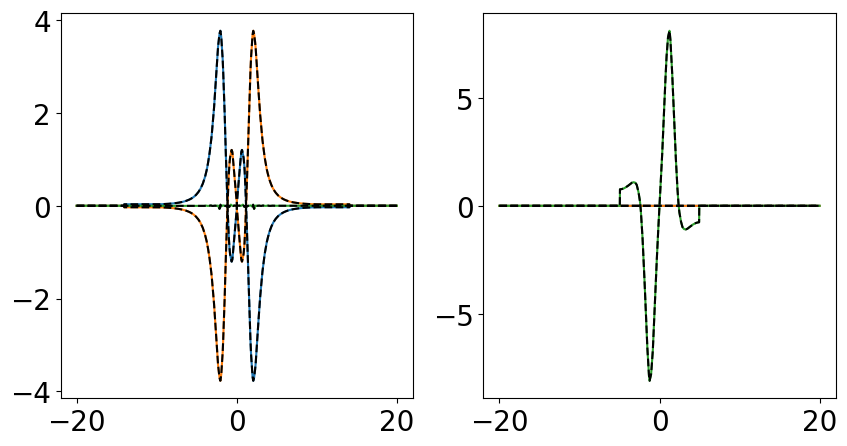

In [50]:
#Now if I make the radial and axial plots, they should still look as expected. Along the line y=-x, By =-Bx by symmetry.
posns = np.arange(-20.0,20.0,0.02)
fig, ax = plt.subplots(1,2,figsize=[10,5])
ax[0].plot(posns,np.array([permMagnets.fieldCartesian(np.array([-i/np.sqrt(2),i/np.sqrt(2),0]),0) for i in posns]))
ax[1].plot(posns,np.array([permMagnets.fieldCartesian(np.array([0.0,0.0,i]),0) for i in posns]))

#checking that the pylcp still gets the same field profiles
ax[0].plot(posns,np.array([permMagnetsPylcp.Field(np.array([-i/np.sqrt(2),i/np.sqrt(2),0]),0) for i in posns]), 'k--')
ax[1].plot(posns,np.array([permMagnetsPylcp.Field(np.array([0.0,0.0,i]),0) for i in posns]), 'k--')

## Capture Velocity

In [64]:
def captured_condition(t, y):
    return (y[-6]**2 + y[-3]**2) - 1e-2/cm_unit

def lost_condition(t, y):
    return y[-3]-2/cm_unit

def backwards_lost(t, y):
    return y[-3] + 12/cm_unit

captured_condition.terminal = True
lost_condition.terminal = True
backwards_lost.terminal = True

def captureVelocityForEq(det_MOT, det_slower, ham, lasers = MOT_and_Slow_Beams):
    print (f"{det_MOT*hertz_unit/1e6:.2f} {det_slower*hertz_unit/1e6:.2f}", end = '                                                                            \r')
    eq = pylcp.rateeq(lasers(det_MOT, det_slower),permMagnetsPylcp, ham,include_mag_forces=False)
    try:
        eq.set_initial_pop(np.array([1., 0., 0., 0.]))
    except ValueError: # Quick and dirty solution to detect the two fermionic hamiltonians
        eq.set_initial_pop(np.array([1., 0., 0., 0., 0., 0., 0., 0.]))
    return findCaptureVelocity(np.array([-10,0,0]), eq)
    

def isCaptured(sol):
    captured = -1
    finalPosition = np.array([sol.r[i][-1] for i in range(3)])
    finalVelocity = np.array([sol.v[i][-1] for i in range(3)]) 
    if (np.linalg.norm(finalPosition)**2 + np.linalg.norm(finalVelocity)**2 <1.1e-2):
        #print('initial velocity: '+ str(sol.v[0][0]) +' captured')
        captured = 1 
    return captured

def atomTrajectoryToMOT(v0, r0, eqn, tmax=10, max_step=1, **kwargs):
    eqn.set_initial_position_and_velocity(r0, np.array([v0,0,0]))
    eqn.evolve_motion([0., 10], events=[captured_condition,lost_condition,backwards_lost],
                      max_step=max_step)

    return isCaptured(eqn.sol)

def findCaptureVelocity(r0,eqn):
    if(atomTrajectoryToMOT(2, r0, eqn, tmax=10, max_step=1)==-1):
        return 0
    return bisect(atomTrajectoryToMOT,2, 40.,
       args=(r0, eqn),
       xtol=1e-3, rtol=1e-3, full_output=False)

In [52]:
rateeq = pylcp.rateeq(MOT_and_Slow_Beams(MOT_detuning,-10), permMagnetsPylcp, gen_Boson_Hamiltonian() ,include_mag_forces=False)

In [53]:
r = np.linspace(-10/cm_unit, 10/cm_unit, 200)
v = np.linspace(-300/velocity_unit, 300/velocity_unit, 200)

R, V = np.meshgrid(r, v)
rateeq.generate_force_profile([R, np.zeros(R.shape), np.zeros(R.shape)],
                           [V, np.zeros(V.shape), np.zeros(V.shape)],
                           name='Frad', progress_bar=True)

Completed in 25.52 s.                                               


In [54]:
rateeq.set_initial_position_and_velocity(np.array([-8/cm_unit, 0., 0.]),np.array([100/velocity_unit, 0., 0.]))
rateeq.set_initial_pop(np.array([1., 0., 0., 0.]))
rateeq.evolve_motion([0., 5e-2/time_unit], events=[captured_condition, lost_condition, backwards_lost], progress_bar=True)
sol = rateeq.sol

Completed in 0.13 s.                                                 


(-300.0, 300.0)

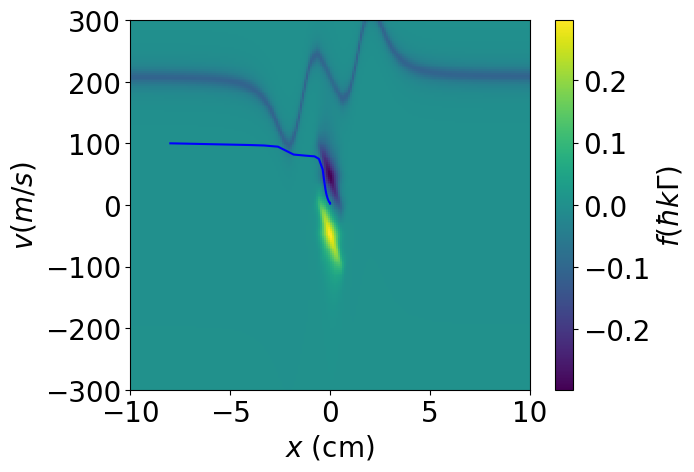

In [55]:
fig, ax = plt.subplots(1, 1)
ax.plot(sol.r[0]*cm_unit,sol.v[0]*velocity_unit,'b-')
colormesh = ax.pcolormesh(R*cm_unit, V*velocity_unit, rateeq.profile['Frad'].F[0], cmap = 'viridis')
cb1 = plt.colorbar(colormesh)
cb1.set_label('$f(\hbar k \Gamma)$')
ax.set_xlabel('$x$ (cm)')
ax.set_ylabel('$v(m/s)$')
fig.subplots_adjust(left=0.12,right=0.9)
ax.set_xlim([-10,10])
ax.set_ylim([-300,300])

In [60]:
isCaptured(sol)

1

## Multi isotope capture vels

In [65]:
MOT_range = np.linspace(-1700e6/hertz_unit, 1700e6/hertz_unit,401)
slower_range = np.linspace(-1700e6/hertz_unit, 1700e6/hertz_unit,41)

In [ ]:
MOT_capture_data = {}
slower_det = -10

for i in isotope_shifts.keys():
    print (f"\n{i}:")
    MOT_capture_data[i] =  [captureVelocityForEq(dMOT, slower_det, Hamiltonians[i], lasers = MOT_Beams) for dMOT in MOT_range]


106:


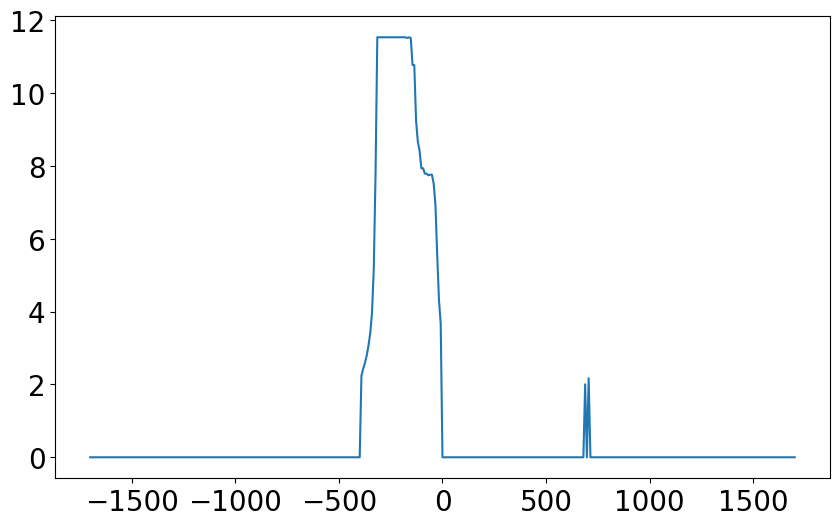

In [69]:
to_be_plotted = None

for i, cap_data in MOT_capture_data.items():
    if to_be_plotted is None:
        to_be_plotted = abundance_data[i]*0 + np.array(cap_data)
        continue
    to_be_plotted += abundance_data[i]*0 + np.array(cap_data)
    
plt.figure(figsize=[10,6])
plt.plot(MOT_range*hertz_unit/1e6, to_be_plotted)

In [70]:
fig.savefig("images/MOT_Scan.png")

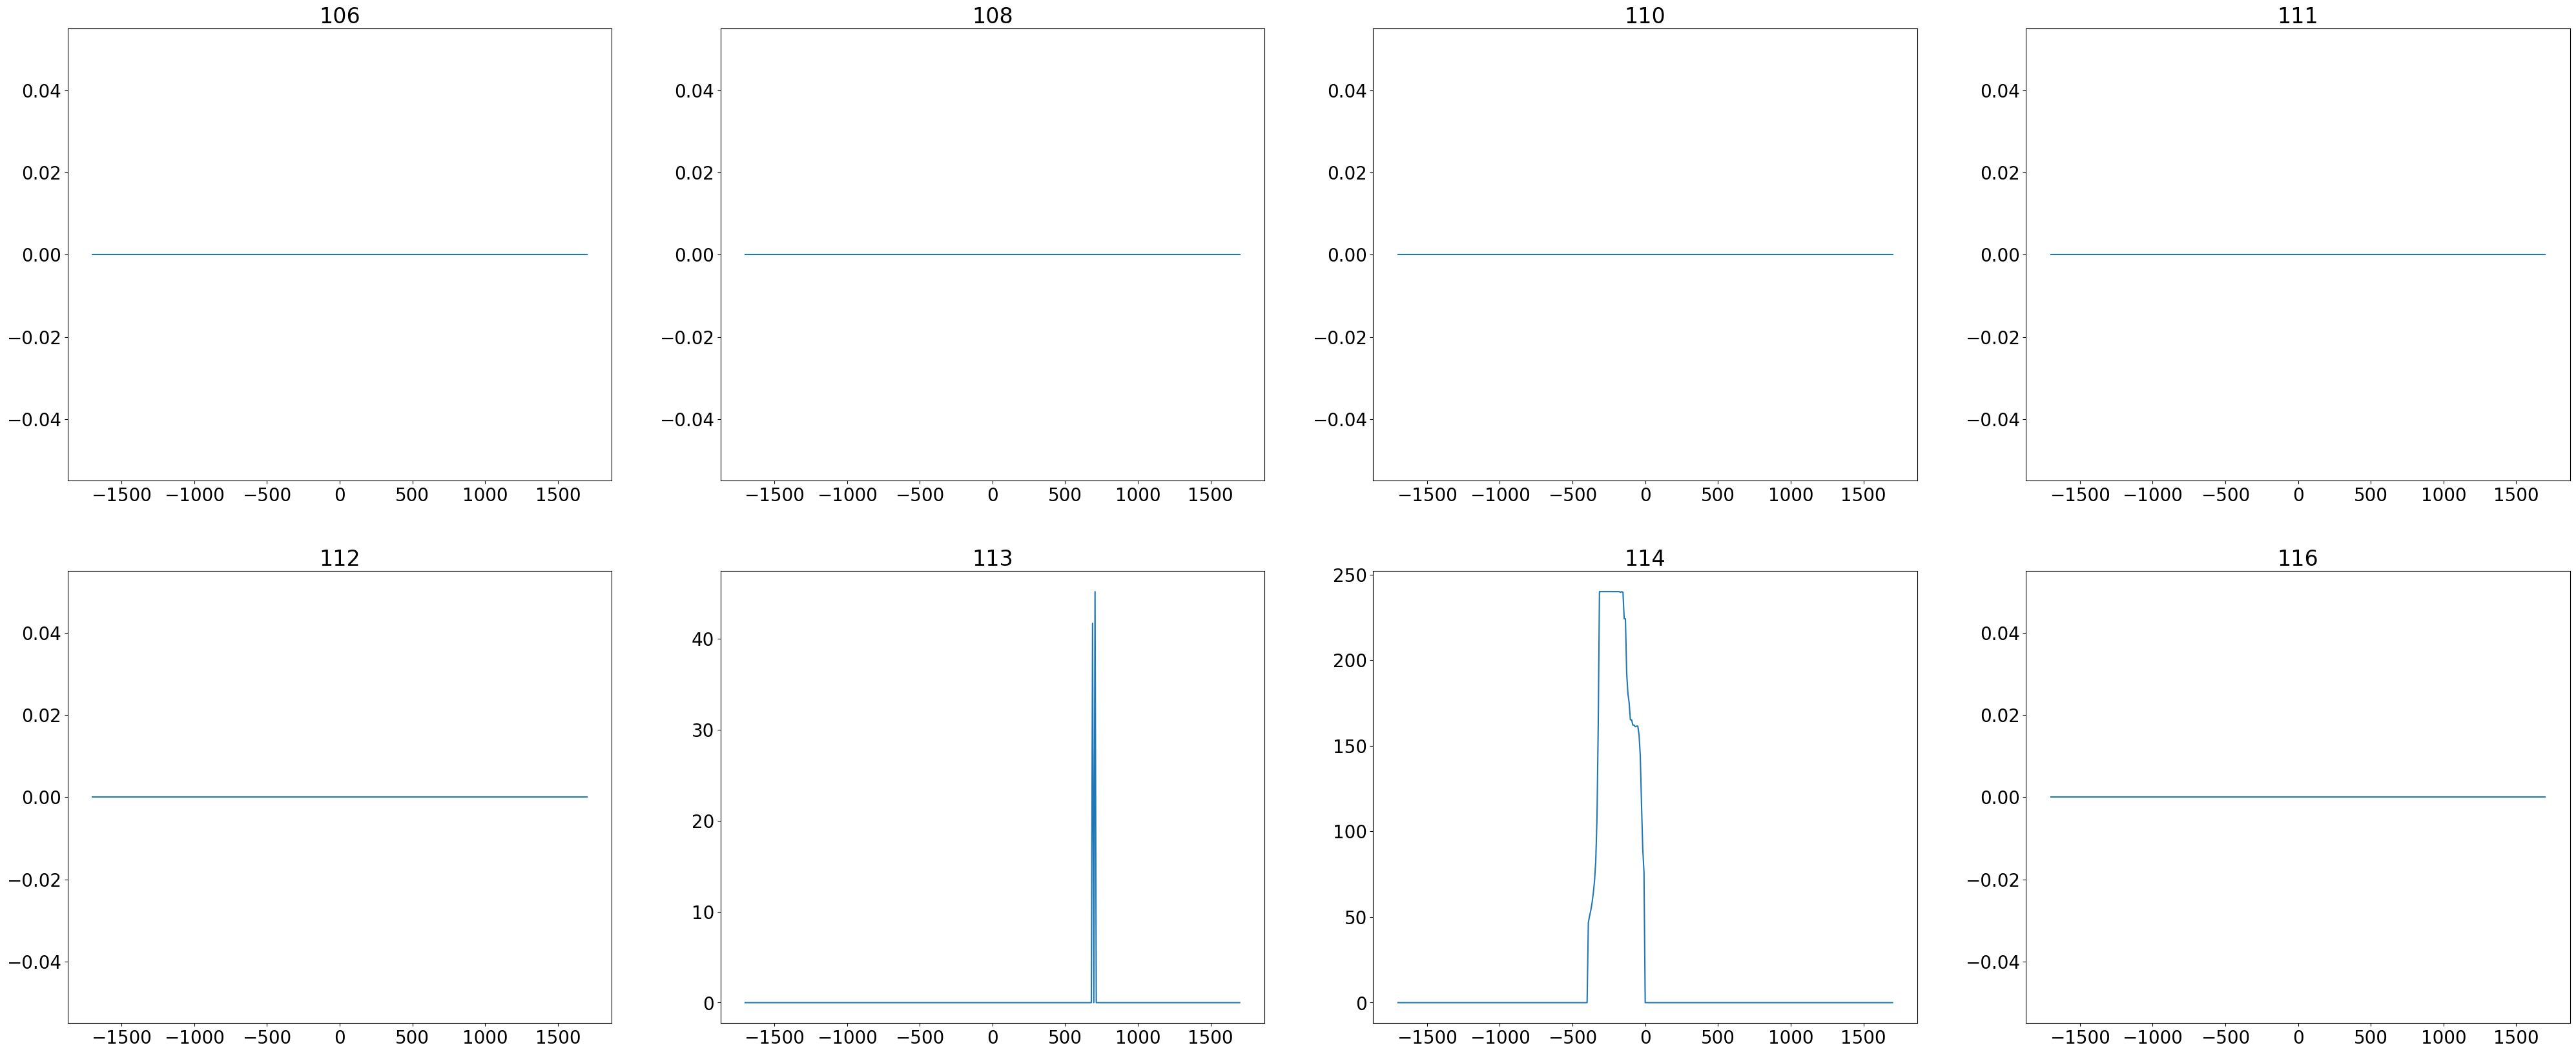

In [71]:
fig, axs =  plt.subplots(2,len(MOT_capture_data.keys())//2,figsize = [50,20])
axs = axs.flatten()
for i, c_data in enumerate(MOT_capture_data.items()):
    axs[i].plot(MOT_range*hertz_unit/1e6, np.array(c_data[1])*velocity_unit)
    axs[i].set_title(c_data[0])

In [72]:
fig.savefig("images/MOT_Scan_tabbed.png")

In [8]:
from scipy.stats import norm

mean = 150/velocity_unit
std = 50/velocity_unit

capture_cdf = lambda x : norm.cdf(x, mean, std)


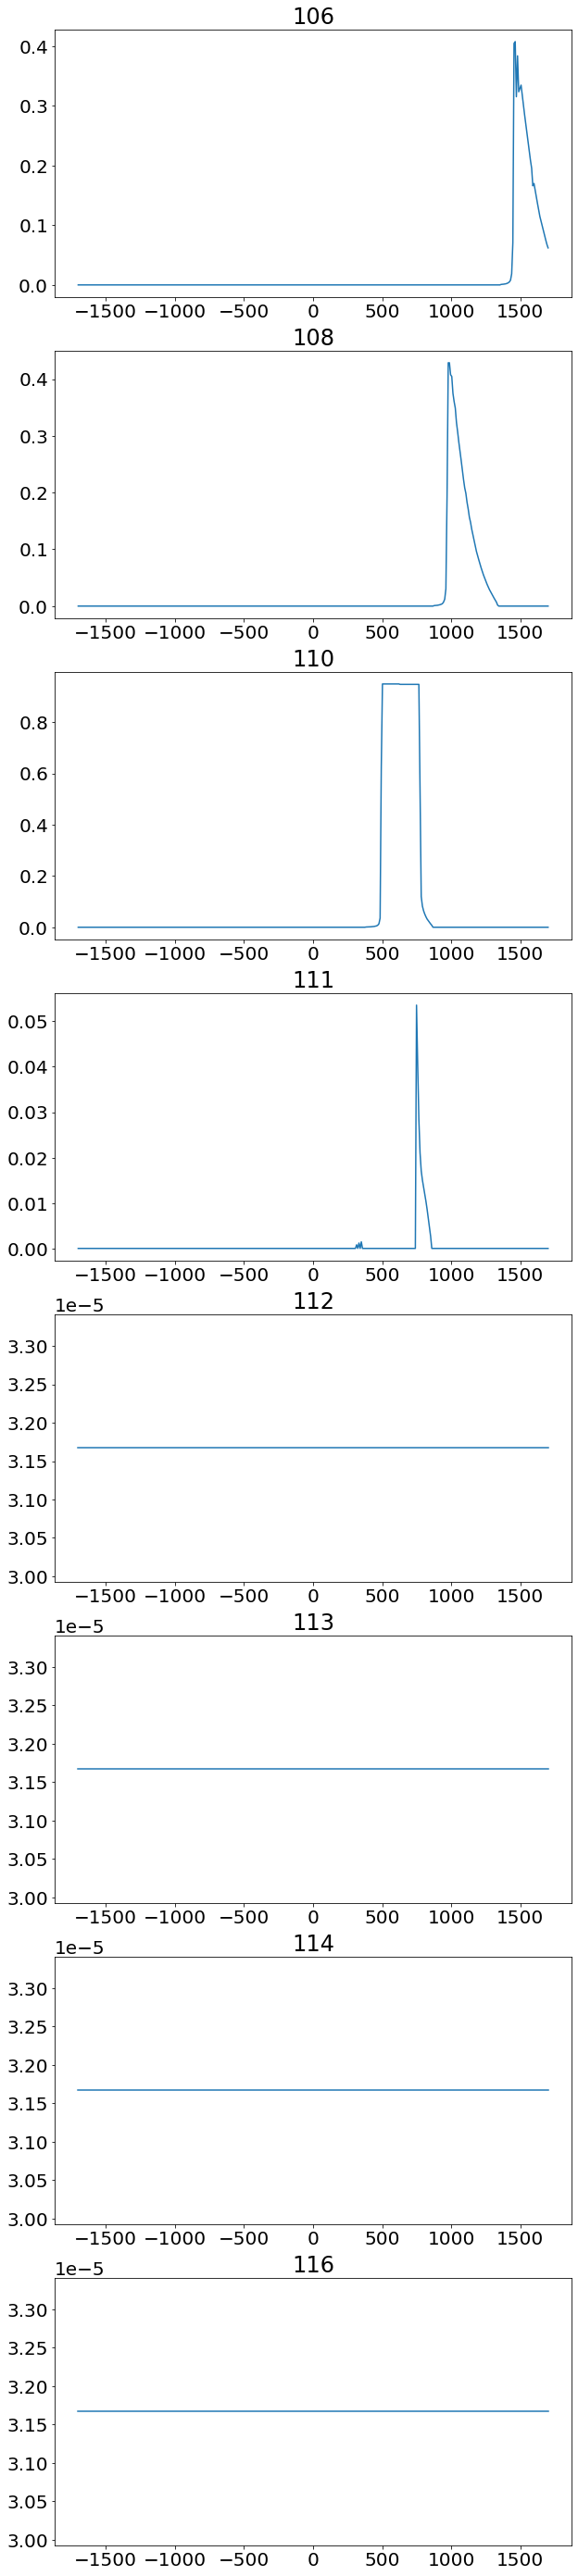

In [347]:
fig, axs =  plt.subplots(len(MOT_capture_data.keys()),figsize = [10,50])
for i, c_data in enumerate(MOT_capture_data.items()):
    axs[i].plot(MOT_range*hertz_unit/1e6, capture_cdf(np.array(c_data[1])))
    axs[i].set_title(c_data[0])

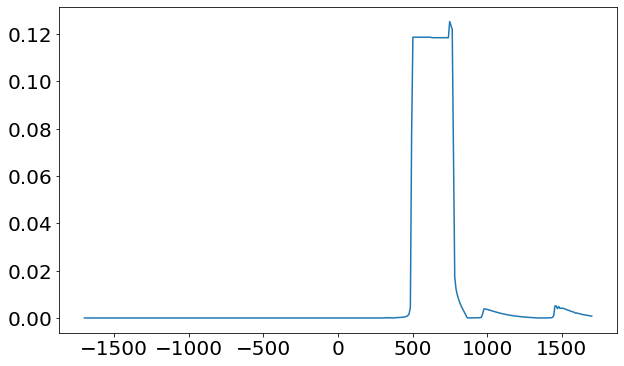

In [348]:
to_be_plotted = None

for i, cap_data in MOT_capture_data.items():
    if to_be_plotted is None:
        to_be_plotted = abundance_data[i]*capture_cdf(np.array(cap_data))
        continue
    to_be_plotted += abundance_data[i]*capture_cdf(np.array(cap_data))
    
fig = plt.figure(figsize=[10,6])
plt.plot(MOT_range*hertz_unit/1e6, to_be_plotted)

### Without slower

In [349]:
MOT_capture_data_wo_slower = {}

for i in isotope_shifts.keys():
    print (f"\n{i}:")
    MOT_capture_data_wo_slower[i] =  [captureVelocityForEq(dMOT, slower_det, Hamiltonians[i], lasers = MOT_Beams) for dMOT in MOT_range]


106:

108:

110:

111:

112:

113:

114:

116:


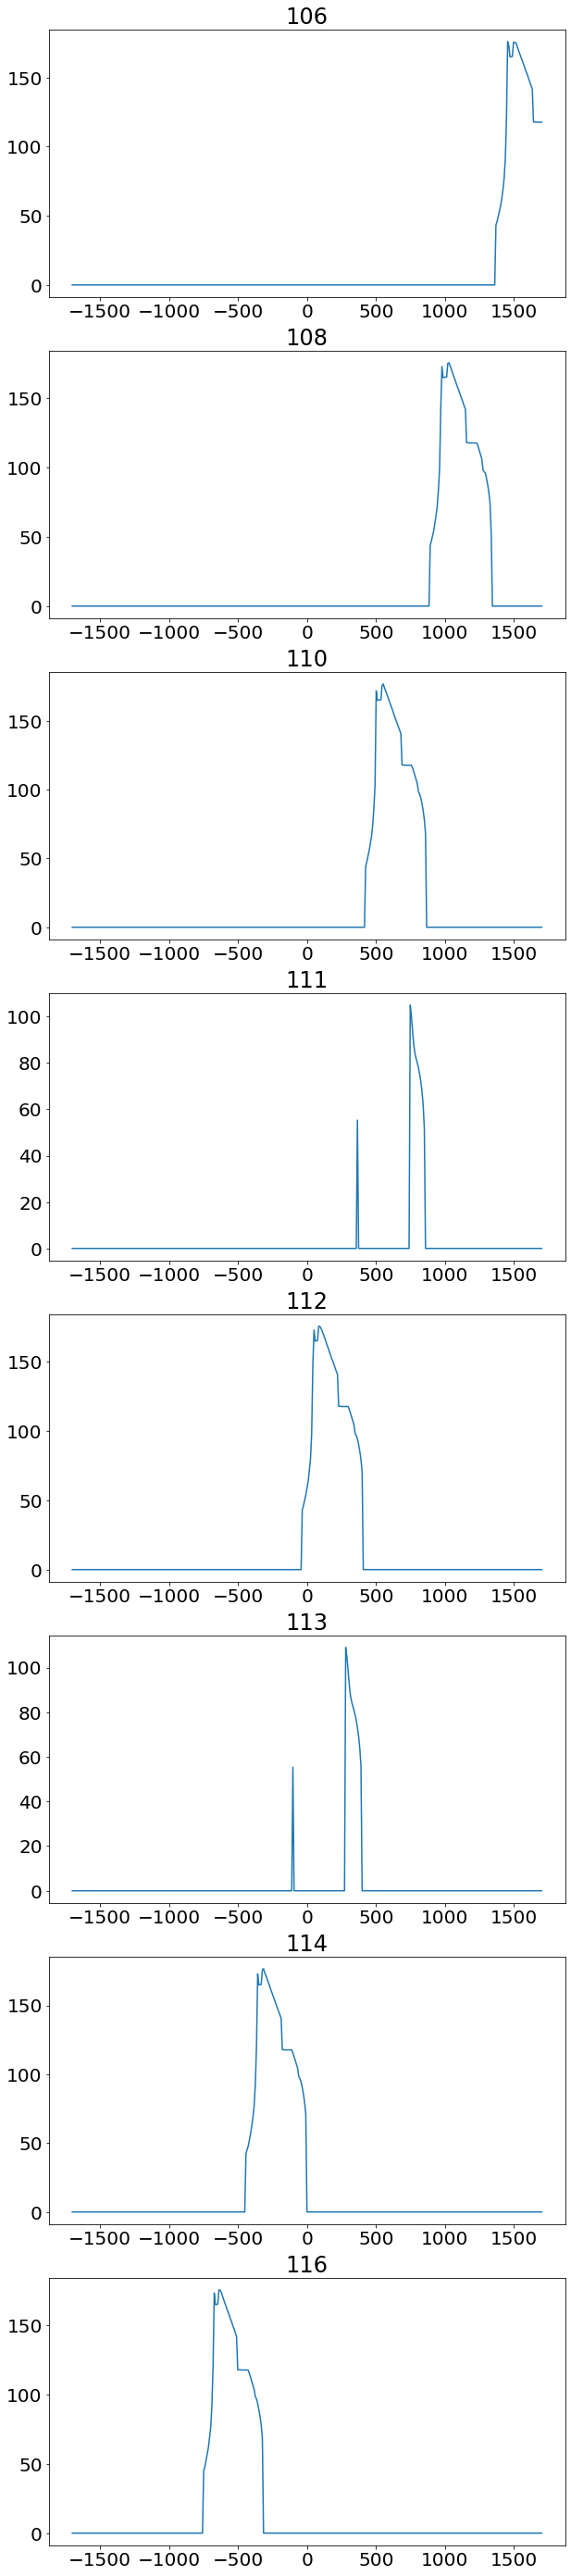

In [350]:
fig, axs =  plt.subplots(len(MOT_capture_data_wo_slower.keys()),figsize = [10,50])
for i, c_data in enumerate(MOT_capture_data_wo_slower.items()):
    axs[i].plot(MOT_range*hertz_unit/1e6, np.array(c_data[1])*velocity_unit)
    axs[i].set_title(c_data[0])

### Shared plot

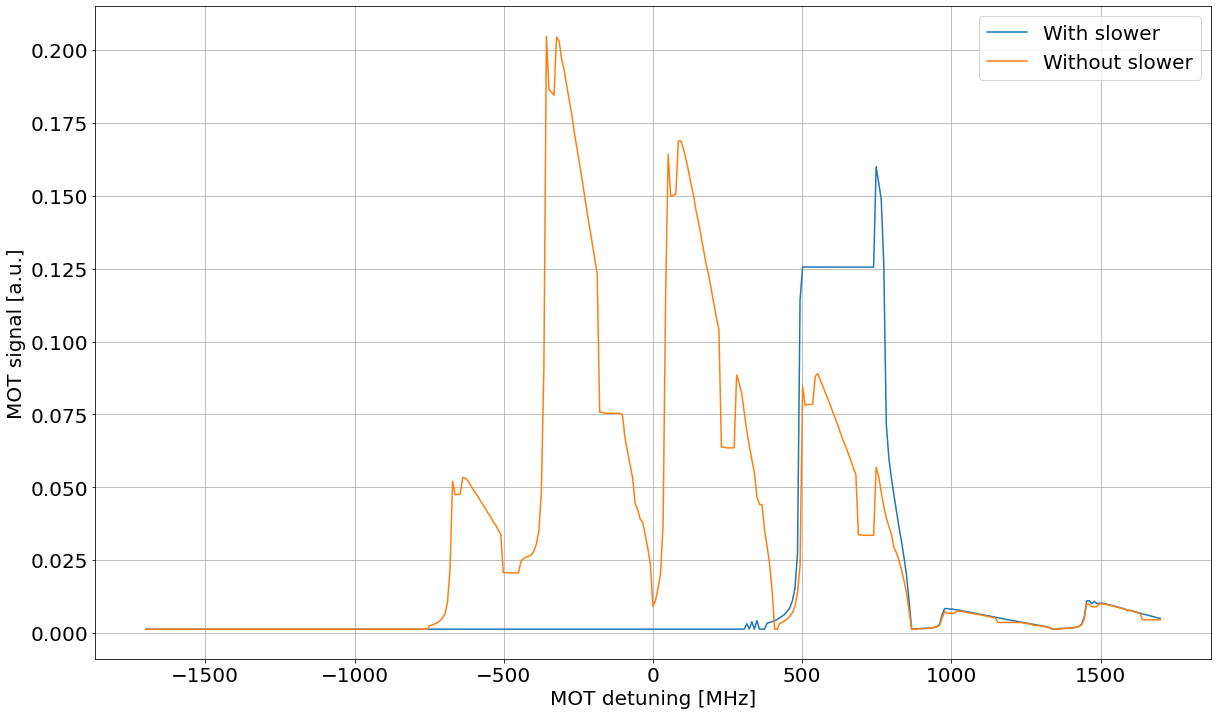

In [355]:
from scipy.stats import norm

mean = 150/velocity_unit
std = 50/velocity_unit

capture_cdf = lambda x : norm.cdf(x, mean, std)


to_be_plotted = None

for i, cap_data in MOT_capture_data.items():
    if to_be_plotted is None:
        to_be_plotted = abundance_data[i]*capture_cdf(np.array(cap_data))
        continue
    to_be_plotted += abundance_data[i]*capture_cdf(np.array(cap_data))
    
fig = plt.figure(figsize=[20,12])
plt.plot(MOT_range*hertz_unit/1e6, to_be_plotted, label = "With slower")

to_be_plotted = None

for i, cap_data in MOT_capture_data_wo_slower.items():
    if to_be_plotted is None:
        to_be_plotted = abundance_data[i]*capture_cdf(np.array(cap_data))
        continue
    to_be_plotted += abundance_data[i]*capture_cdf(np.array(cap_data))

plt.plot(MOT_range*hertz_unit/1e6, to_be_plotted, label = "Without slower")
plt.xlabel("MOT detuning [MHz]")
plt.ylabel("MOT signal [a.u.]")
plt.legend()
plt.grid()

In [356]:
plt.savefig("images/slower_enhancement_MOT_scan.pdf")

<Figure size 432x288 with 0 Axes>

## Slower Scan

In [9]:
MOT_range = np.linspace(-1700e6/hertz_unit, 1700e6/hertz_unit,401)
slower_range = np.linspace(-1700e6/hertz_unit, 1700e6/hertz_unit,41)

In [10]:
slower_capture_data = []

beams = [MOT_and_Slow_Beams, MOT_and_Slow_Beams_sig_2, MOT_and_Slow_Beams_lin]
relevant_isotopes = [114, 116, 113]

for i in beams:
    print(1)
    slower_capture_data.append(None)
    for h in relevant_isotopes:
        print(h)
        if slower_capture_data[-1] is None:
            slower_capture_data[-1] = capture_cdf(abundance_data[h]*np.array([captureVelocityForEq(MOT_detuning, dSlower, Hamiltonians[h],lasers=i) for dSlower in slower_range]))
            continue
        slower_capture_data[-1] += capture_cdf(abundance_data[h]*np.array([captureVelocityForEq(MOT_detuning, dSlower, Hamiltonians[h],lasers=i) for dSlower in slower_range]))

1
114
116
113


c:\Users\LP618\AppData\Local\Programs\Python\Python310\lib\site-packages\pylcp\rateeq.py:264: ComplexWarning: Casting complex values to real discards the imaginary part
  self.Rijl[key][ll] = gamma*intensity/2*\


1
114
116
113
1
114
116
113


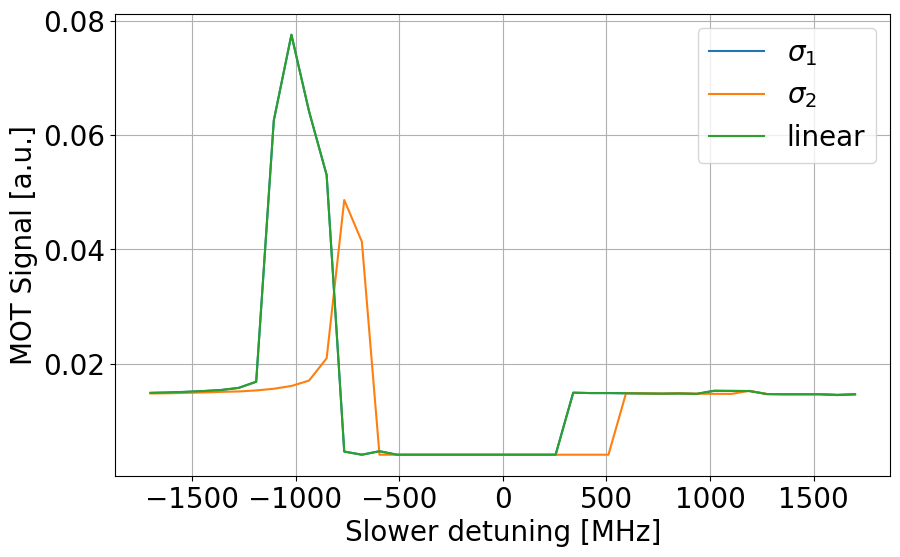

In [14]:
fig = plt.figure(figsize=[10,6])
labels = ["$\\sigma_1$","$\\sigma_2$","linear"]
for i in range(len(slower_capture_data)):
    plt.plot(slower_range*hertz_unit/1e6, slower_capture_data[i],label=labels[i])
plt.grid()
plt.xlabel("Slower detuning [MHz]")
plt.ylabel("MOT Signal [a.u.]")
plt.legend()

In [12]:
fig.savefig("images/Slower_scan.pdf")

## 2D Scan

In [16]:
MOT_range = np.arange(-750e6/hertz_unit, 2100e6/hertz_unit + 50e6/hertz_unit,50e6/hertz_unit)
slower_range = np.arange(-1700e6/hertz_unit, 1700e6/hertz_unit + 100e6/hertz_unit,100e6/hertz_unit)

In [17]:
import multiprocessing as mp

In [ ]:
capture_data = {}
c_data = []

def run_cap_vel_scan(i):
    cap_vels = []
    for dSlow in slower_range:
        print (f"{dSlow*hertz_unit/1e6:.2f}\r",end="")
        cap_vels.append([captureVelocityForEq(dMOT, dSlow, Hamiltonians[i]) for dMOT in MOT_range])
    return (i,cap_vels)

with mp.Pool(processes=8) as pool:
    c_data =  pool.map(run_cap_vel_scan, Hamiltonians.keys())

for i, cdata in c_data:
    capture_data[i] = cdata

In [371]:
np.savez('data/capture_data.npz',capture_data=c_data,MOT_range=MOT_range,slower_range=slower_range)

/home/lala5th/.local/venvs/default/lib/python3.10/site-packages/numpy/lib/npyio.py:696: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  val = np.asanyarray(val)


In [364]:
saved_data = np.load('data/capture_data.npz', allow_pickle=True)

c_data = saved_data["capture_data"]
MOT_range = saved_data['MOT_range']
slower_range = saved_data['slower_range']

for i, cdata in c_data:
    capture_data[i] = cdata

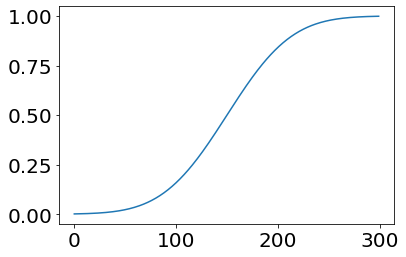

In [372]:
mean = 150/velocity_unit
std = 50/velocity_unit

capture_cdf = lambda x : norm.cdf(x, mean, std)

xs = np.arange(0,300,1.)
plt.plot(xs,capture_cdf(xs/velocity_unit))

In [ ]:
to_be_plotted = None

for i, cap_data in capture_data.items():
    if to_be_plotted is None:
        to_be_plotted = abundance_data[i]*capture_cdf(np.array(cap_data))
        continue
    to_be_plotted += abundance_data[i]*capture_cdf(np.array(cap_data))
    
plt.figure(figsize=[20,20])
plt.axes().set_aspect('equal')
plt.pcolormesh(*np.meshgrid(MOT_range*hertz_unit/1e6, slower_range*hertz_unit/1e6), to_be_plotted, cmap = 'gnuplot')
plt.xlabel("MOT detuning -$\\nu_{114}$ [MHz]")
plt.ylabel("Slower detuning -$\\nu_{114}$ [MHz]")
cbar = plt.colorbar()
cbar.set_label("MOT signal [a.u.]")

In [376]:
fig.savefig("images/MOT_Dual_Scan.pdf")

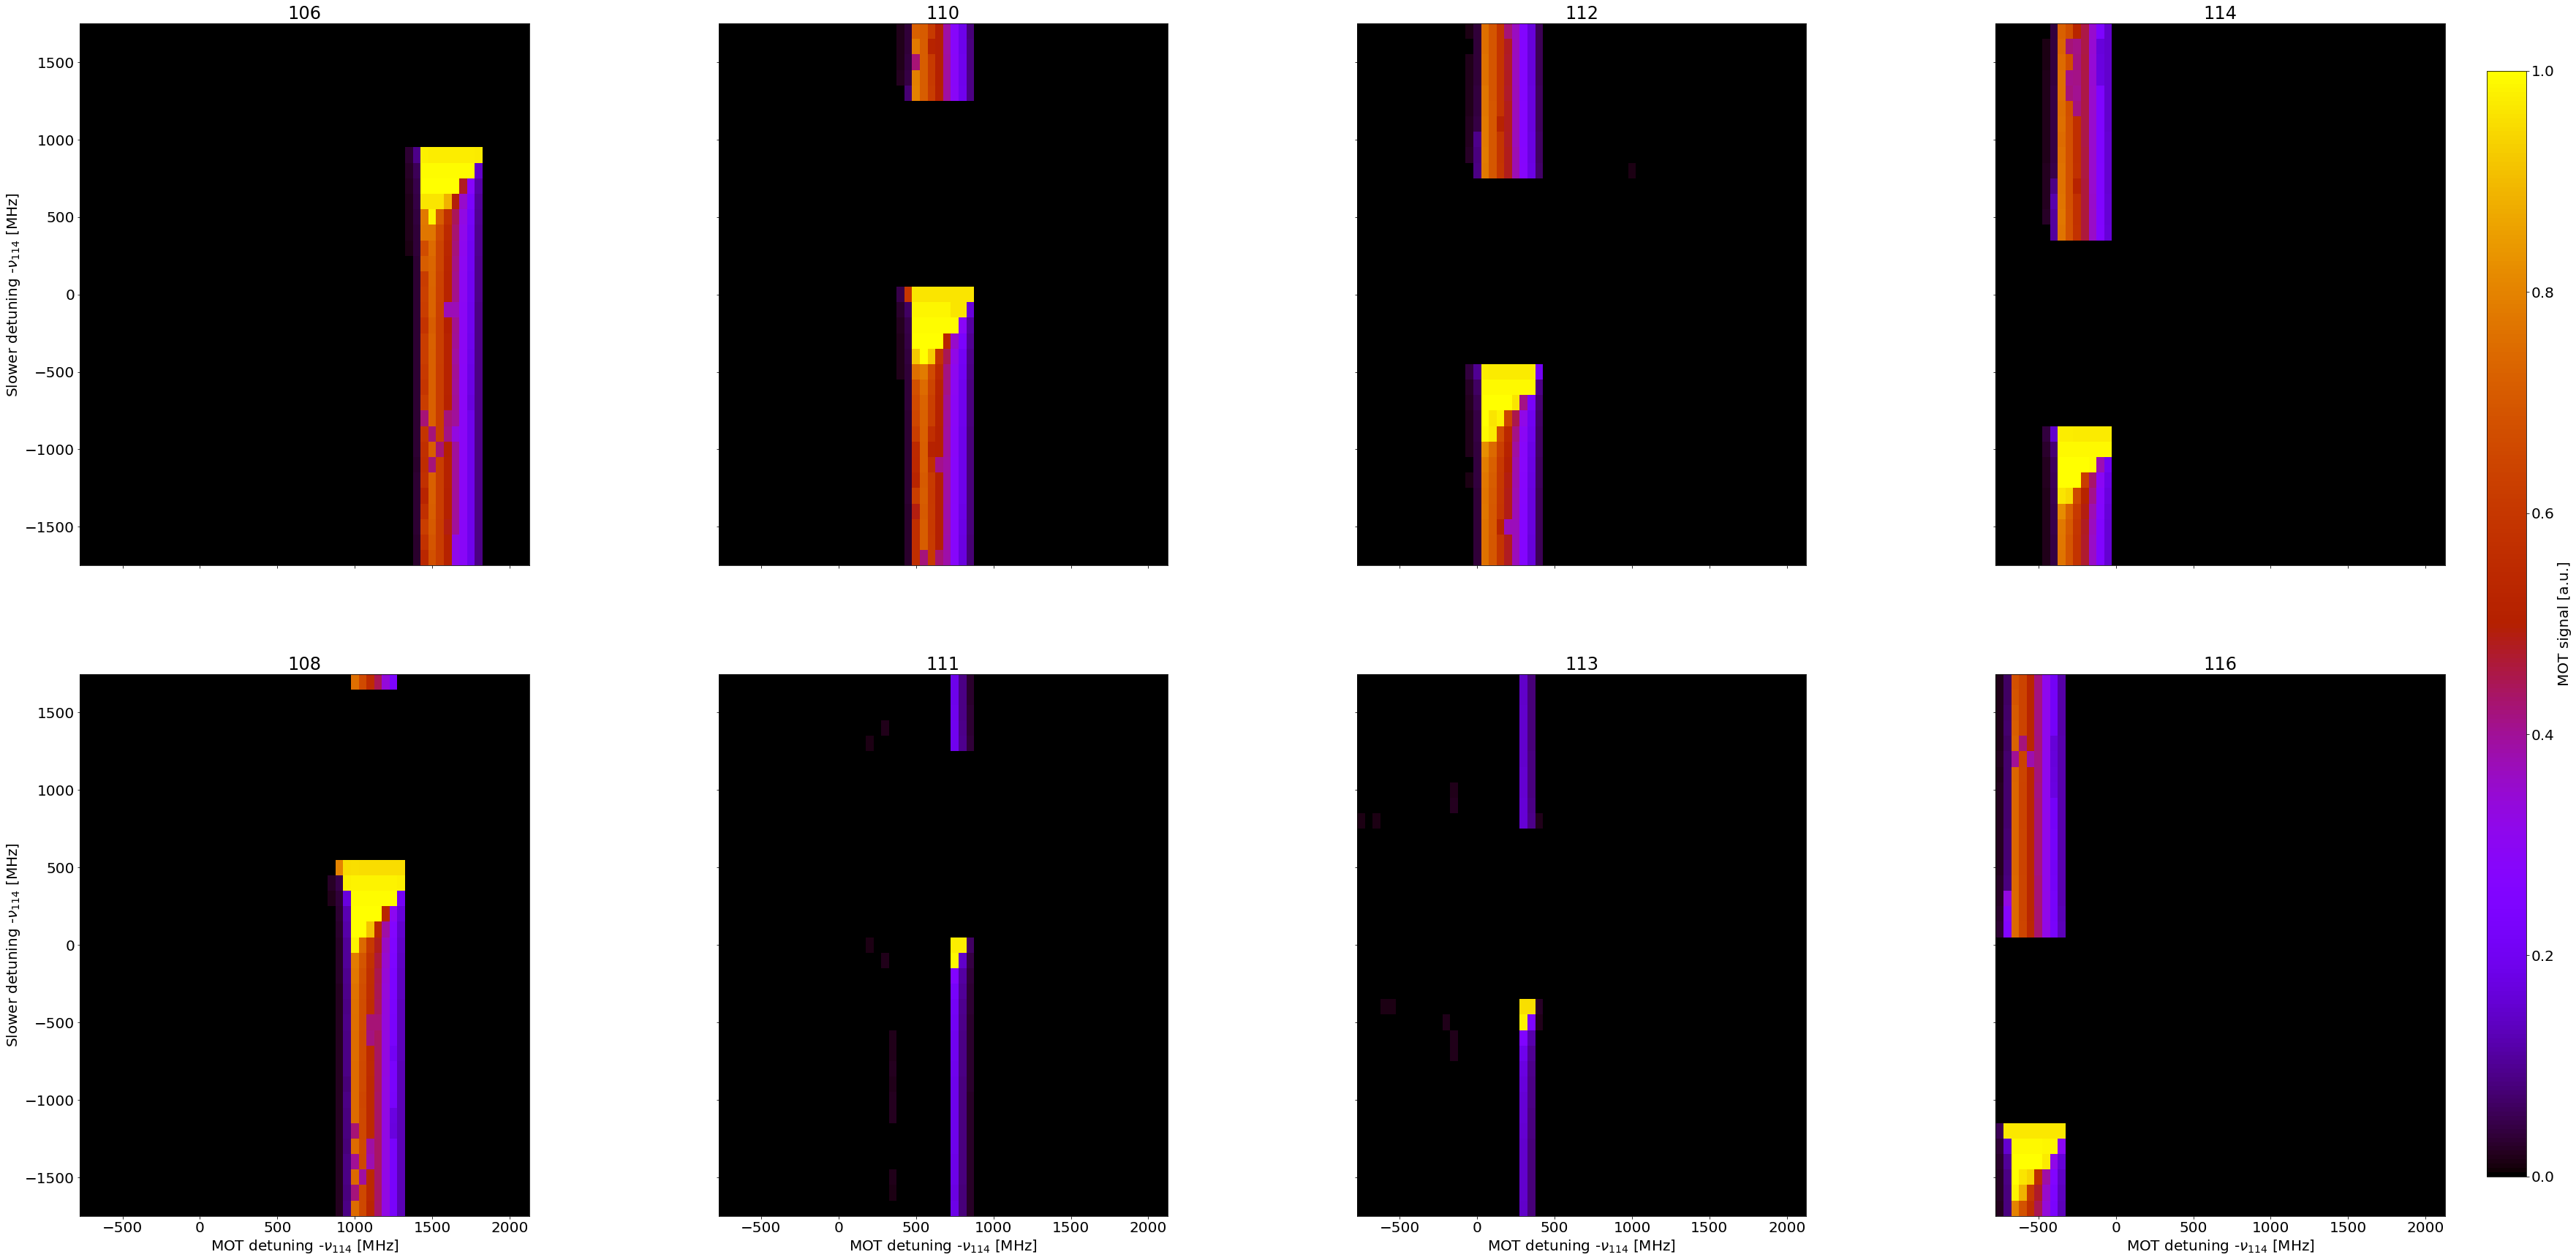

In [378]:
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable

color_norm = Normalize(0,1)
fig, axs = plt.subplots(2,len(capture_data.values())//2,figsize=[60,30],sharex=True, sharey=True)
fig.subplots_adjust(right=0.9)
axs = axs.T.flatten()
for i, c_data in enumerate(capture_data.items()):

    axs[i].set_aspect('equal')
    axs[i].set_title(c_data[0])
    colormesh = axs[i].pcolormesh(*np.meshgrid(MOT_range*hertz_unit/1e6, slower_range*hertz_unit/1e6), capture_cdf(np.array(c_data[1])), cmap = 'gnuplot', norm = color_norm)
    if i in [1,3,5,7]:
        axs[i].set_xlabel("MOT detuning -$\\nu_{114}$ [MHz]")
    if i in [0,1]:
        axs[i].set_ylabel("Slower detuning -$\\nu_{114}$ [MHz]")
cbar_ax = fig.add_axes([0.9, 0.15, 0.0125, 0.7])
cbar = fig.colorbar(ScalarMappable(norm = color_norm, cmap = 'gnuplot'), cax = cbar_ax)
cbar.set_label("MOT signal [a.u.]")


In [379]:
fig.savefig("images/MOT_Dual_Scan_tabbed.pdf")

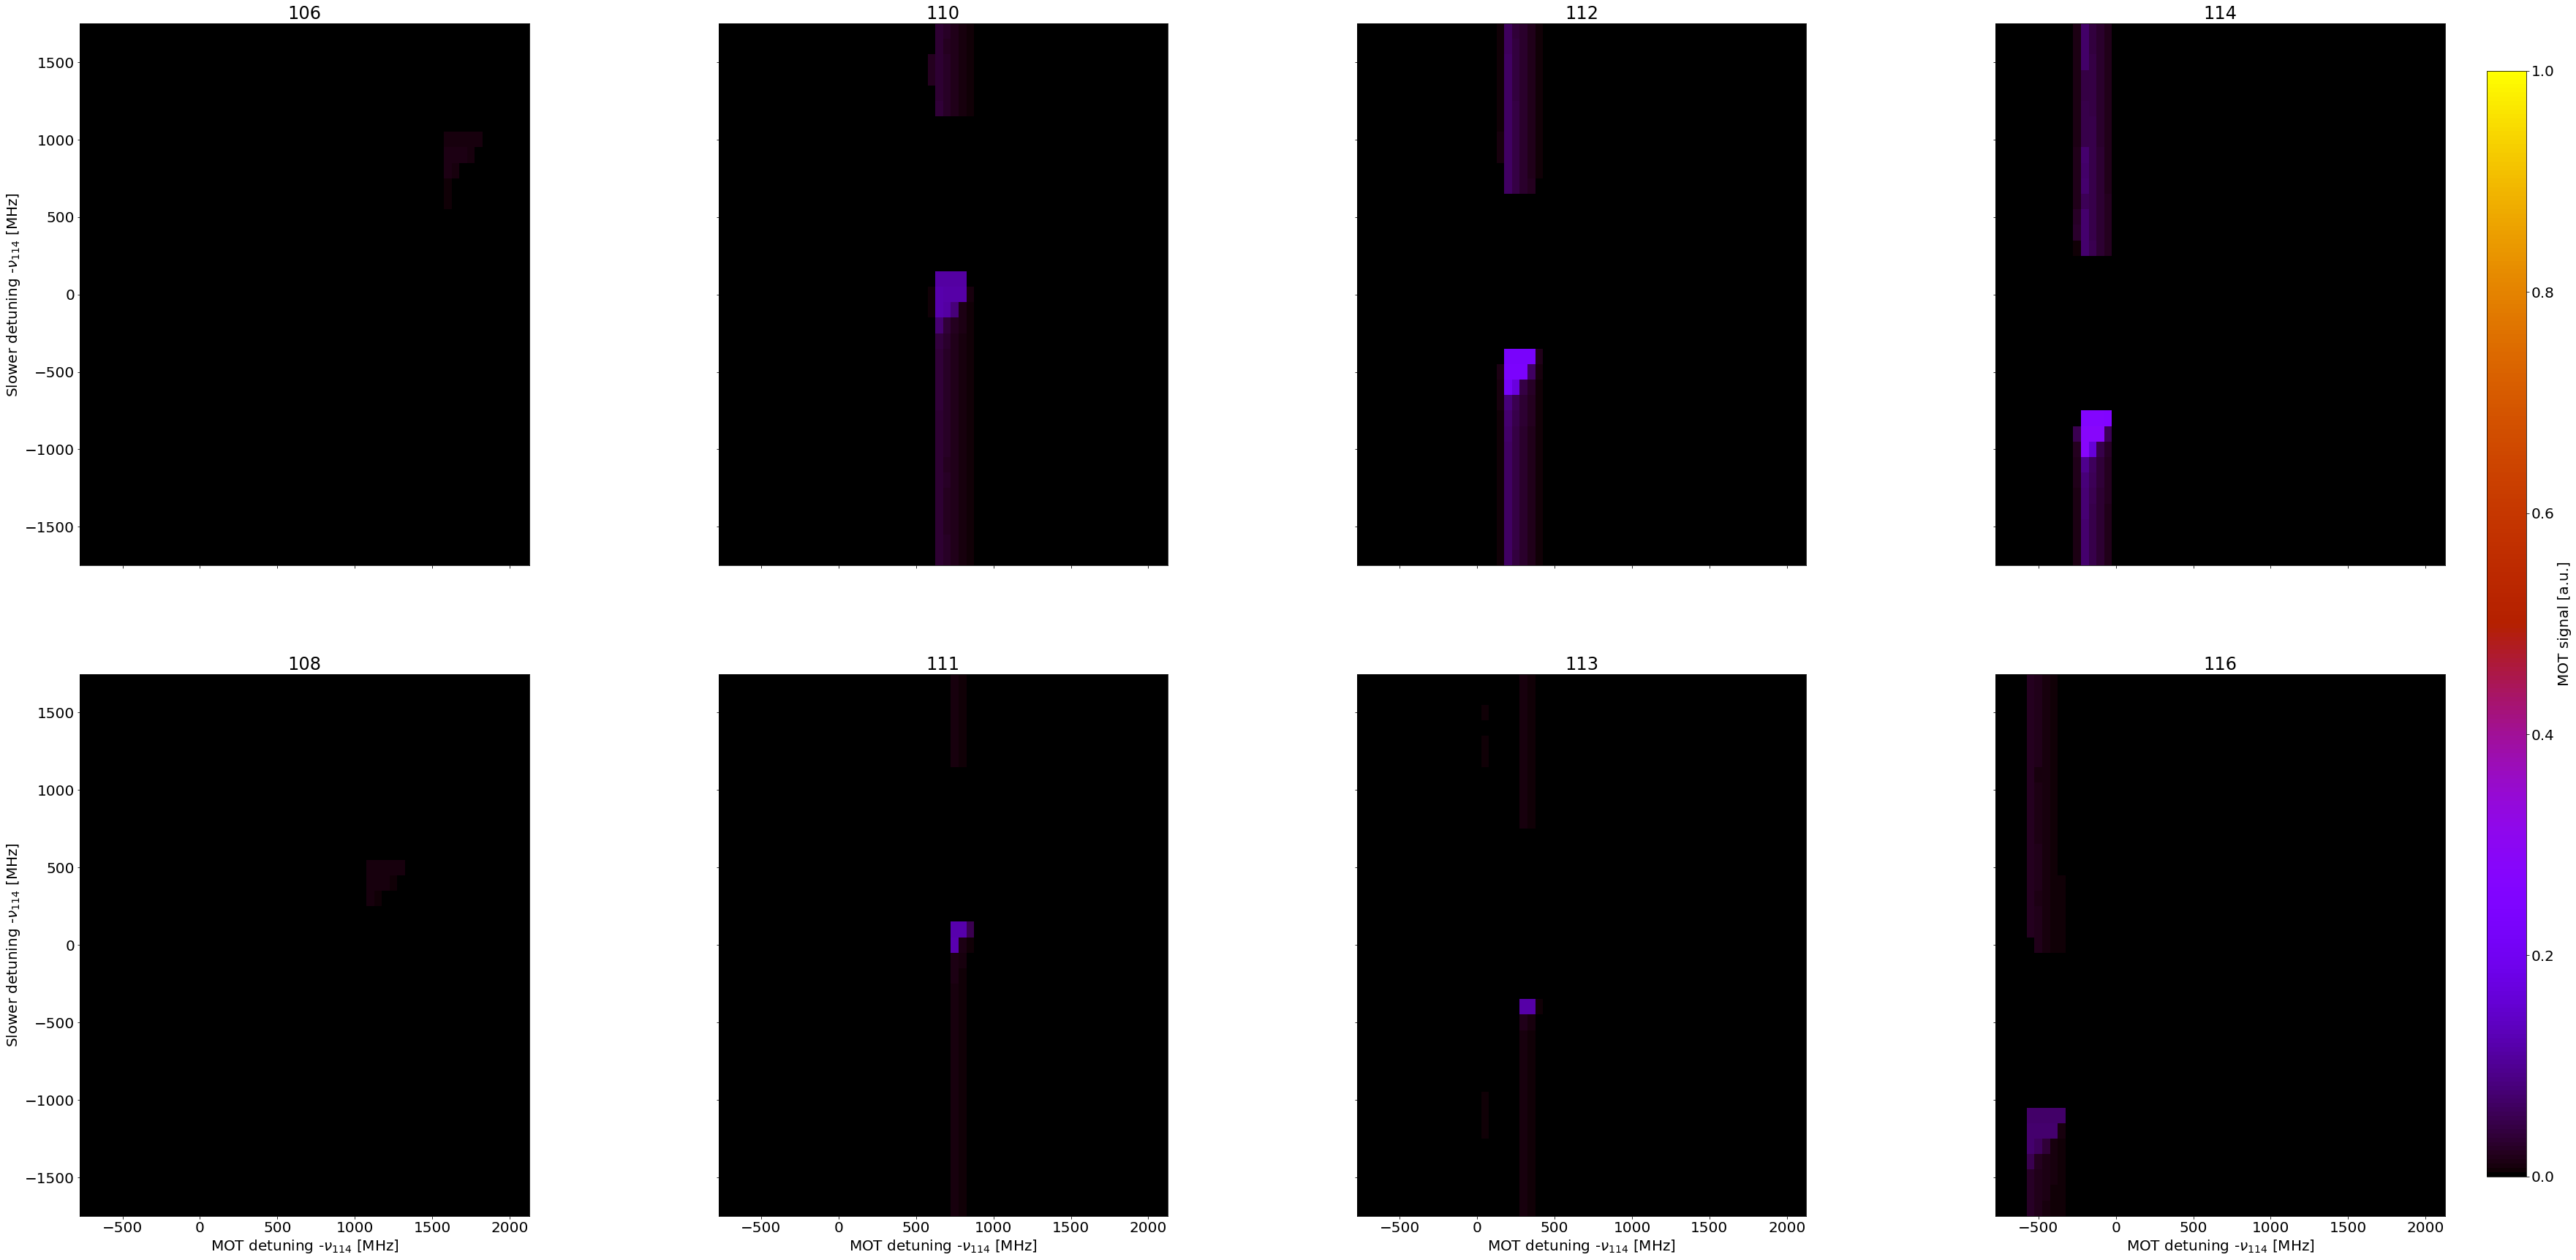

In [295]:
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable

color_norm = Normalize(0,1)
fig, axs = plt.subplots(2,len(capture_data.values())//2,figsize=[60,30],sharex=True, sharey=True)
fig.subplots_adjust(right=0.9)
axs = axs.T.flatten()
for i, c_data in enumerate(capture_data.items()):

    axs[i].set_aspect('equal')
    axs[i].set_title(c_data[0])
    colormesh = axs[i].pcolormesh(*np.meshgrid(MOT_range*hertz_unit/1e6, slower_range*hertz_unit/1e6), abundance_data[c_data[0]]*capture_cdf(np.array(c_data[1])), cmap = 'gnuplot', norm = color_norm)
    if i in [1,3,5,7]:
        axs[i].set_xlabel("MOT detuning -$\\nu_{114}$ [MHz]")
    if i in [0,1]:
        axs[i].set_ylabel("Slower detuning -$\\nu_{114}$ [MHz]")
cbar_ax = fig.add_axes([0.9, 0.15, 0.0125, 0.7])
cbar = fig.colorbar(ScalarMappable(norm = color_norm, cmap = 'gnuplot'), cax = cbar_ax)
cbar.set_label("MOT signal [a.u.]")


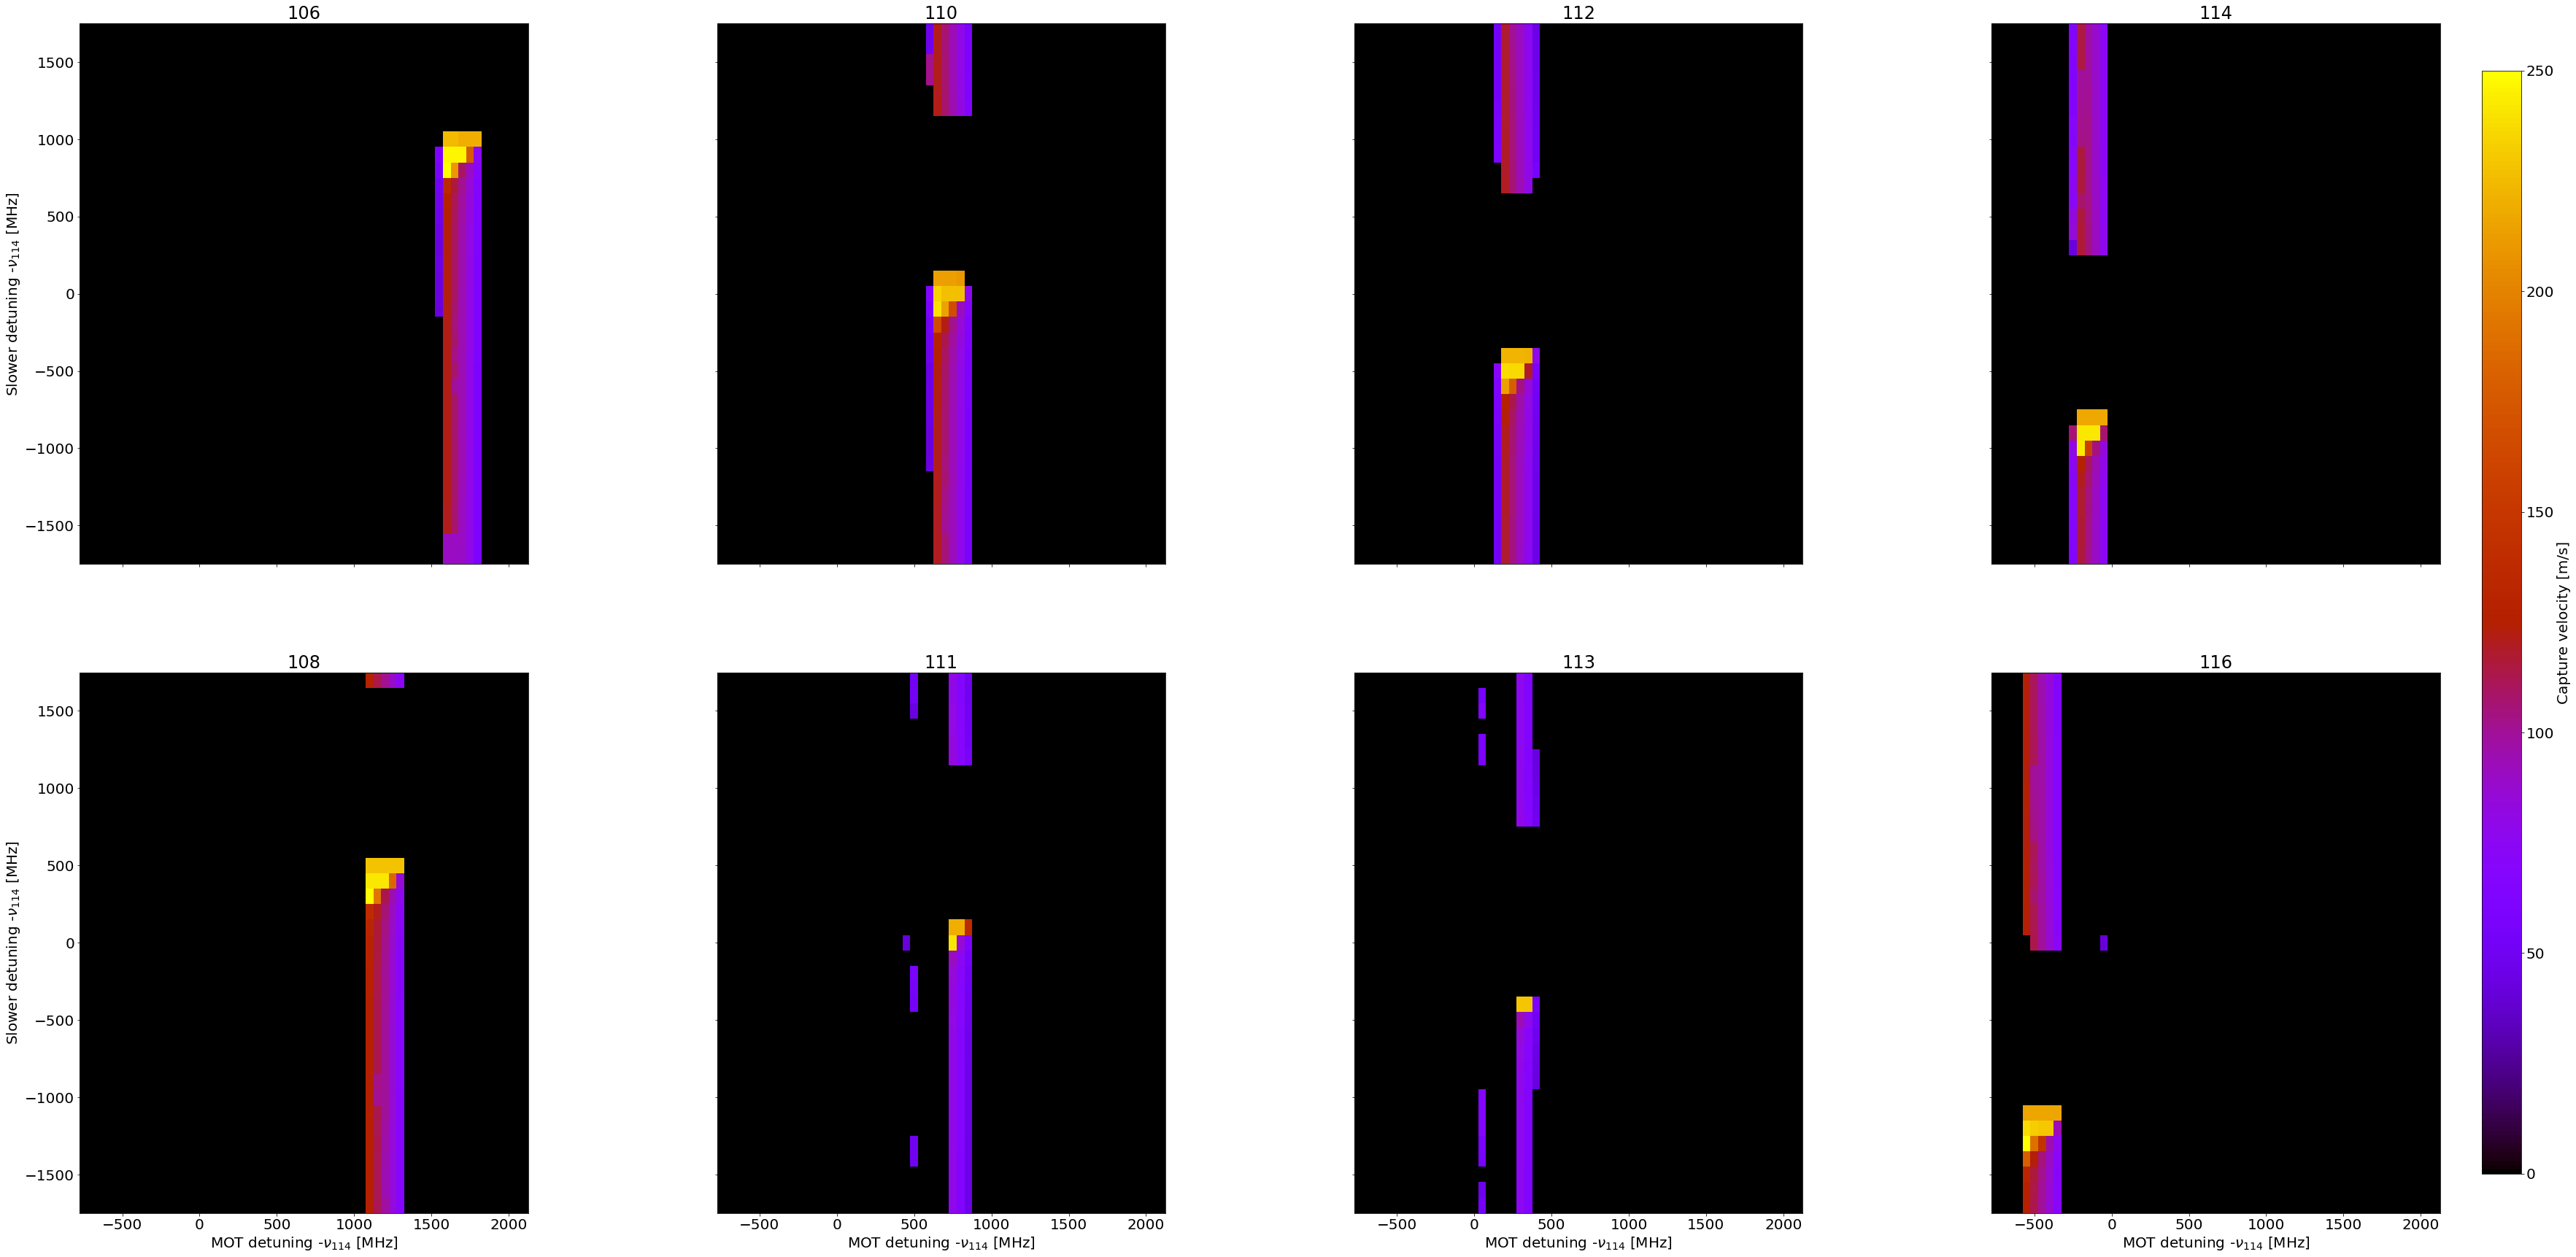

In [296]:
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable

color_norm = Normalize(0,250)
fig, axs = plt.subplots(2,len(capture_data.values())//2,figsize=[60,30],sharex=True, sharey=True)
fig.subplots_adjust(right=0.9)
axs = axs.T.flatten()
for i, c_data in enumerate(capture_data.items()):

    axs[i].set_aspect('equal')
    axs[i].set_title(c_data[0])
    colormesh = axs[i].pcolormesh(*np.meshgrid(MOT_range*hertz_unit/1e6, slower_range*hertz_unit/1e6), np.array(c_data[1])*velocity_unit, cmap = 'gnuplot', norm = color_norm)
    if i in [1,3,5,7]:
        axs[i].set_xlabel("MOT detuning -$\\nu_{114}$ [MHz]")
    if i in [0,1]:
        axs[i].set_ylabel("Slower detuning -$\\nu_{114}$ [MHz]")
cbar_ax = fig.add_axes([0.9, 0.15, 0.0125, 0.7])
cbar = fig.colorbar(ScalarMappable(norm = color_norm, cmap = 'gnuplot'), cax = cbar_ax)
cbar.set_label("Capture velocity [m/s]")
